In [282]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [283]:
data_raw = pd.read_csv('.//data//train.csv')
print("Number of rows in data =",data_raw.shape[0])
print("Number of columns in data =",data_raw.shape[1])
print("\n")
print("**Sample data:**")
data_raw.head()

Number of rows in data = 159571
Number of columns in data = 8


**Sample data:**


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [284]:
data_raw = data_raw.iloc[:2000, :]
data_raw.shape

(2000, 8)

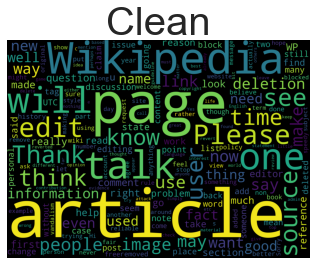

In [285]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(10,4))
# clean
subset = data_raw
text = subset.comment_text.values
cloud_toxic = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Clean",fontsize=40)
plt.imshow(cloud_toxic)
# Same code can be used to generate wordclouds of other categories.

In [286]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
data = data_raw
if not sys.warnoptions:
    warnings.simplefilter("ignore")
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent
data['comment_text'] = data['comment_text'].str.lower()
data['comment_text'] = data['comment_text'].apply(cleanHtml)
data['comment_text'] = data['comment_text'].apply(cleanPunc)
data['comment_text'] = data['comment_text'].apply(keepAlpha)

In [287]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
data['comment_text'] = data['comment_text'].apply(stemming)

In [288]:
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explan whi the edit made under my usernam hard...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww he match this background colour im seem s...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im realli not tri to edit war it just ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cant make ani real suggest on improv i ...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero ani chanc you rememb what ...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
1995,05674d53bc1e4518,barek whi are you abu ing the delet function y...,0,0,0,0,0,0
1996,056791b78692a149,hannib like i said earlier the onli thing id c...,0,0,0,0,0,0
1997,05687bcb86751fc2,the ctmu is not pass itself off as an academ t...,0,0,0,0,0,0
1998,0569a07e22b86f53,siafu i am get access deni for gps pps it say ...,0,0,0,0,0,0


### set TF-IDF 

In [289]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
836,0246bad2d4571175,at bookfind com i found probabilist reason in ...,0,0,0,0,0,0
575,0182543bde139103,you need to prove notabl use reliabl sourc jus...,0,0,0,0,0,0
557,01754d101f511048,nope i didnt read the guid to appeal didnt hav...,0,0,0,0,0,0


In [290]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(2,3), norm='l2')
vectorizer.fit(train.comment_text)
vectorizer.fit(test.comment_text)
x_train = vectorizer.transform(train.comment_text)
y_train = train.drop(labels = ['id','comment_text'], axis=1)
x_test = vectorizer.transform(test.comment_text)
y_test = test.drop(labels = ['id','comment_text'], axis=1)

###  “one-to-rest” strategy
The main assumption here is that the labels are mutually exclusive. You do not consider any underlying correlation between the classes in this method.

In [291]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [292]:
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('reg_clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),])

In [293]:
categories = data.columns[2:]

In [294]:
for category in categories:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print("\n")

**Processing toxic comments...**
Test accuracy is 0.8866666666666667


**Processing severe_toxic comments...**
Test accuracy is 0.9866666666666667


**Processing obscene comments...**
Test accuracy is 0.9433333333333334


**Processing threat comments...**
Test accuracy is 0.9966666666666667


**Processing insult comments...**
Test accuracy is 0.9433333333333334


**Processing identity_hate comments...**
Test accuracy is 0.99




### Binary Relevance
if there’s q labels, the binary relevance method create q new data sets from the images, one for each label and train single-label classifiers on each new data set

In [295]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())
# train
classifier.fit(x_train, y_train)
# predict
predictions = classifier.predict(x_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))


Accuracy =  0.8516666666666667


### Classifier Chains
classifier chains (CC), can take into account label correlations. the training of the classifiers is more involved.

In [296]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

In [297]:
# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression(random_state=123))
# Training logistic regression model on train data
classifier.fit(x_train, y_train)
# predict
predictions = classifier.predict(x_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

Accuracy =  0.88




In [298]:
print(predictions.todense())

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [299]:
y_test[y_test.toxic == 1]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
65,1,0,1,0,1,0
56,1,0,1,0,1,0
1292,1,0,0,0,0,0
746,1,1,1,0,0,0
1664,1,0,0,0,0,0
...,...,...,...,...,...,...
1096,1,0,0,0,0,0
497,1,0,0,0,1,0
756,1,1,1,0,1,0
1554,1,0,1,0,0,0


### Label Powerset
This method needs worst case (2^|C|) classifiers (81)

In [300]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset

In [301]:
# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression())
# train
classifier.fit(x_train, y_train)
# predict
predictions = classifier.predict(x_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

Accuracy =  0.88




### Adapted Algorithm
implements algorithm adaptation approaches to multi-label classification, including but not limited to ML-KNN.

In [302]:
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.model_selection import GridSearchCV
parameters = {'k': range(1,3), 's': [0.5, 0.7, 1.0]}
score = 'f1_macro'

In [303]:
classifier_new = MLkNN(k=6)
x_train = lil_matrix(x_train).toarray()
y_train = lil_matrix(y_train).toarray()
x_test = lil_matrix(x_test).toarray()

# train
classifier_new.fit(x_train, y_train)

# predict
predictions_new = classifier_new.predict(x_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions_new))
print("\n")

Accuracy =  0.88




In [304]:
# a multi-Label Hierarchical ARAM Neural Network

from skmultilearn.adapt import MLARAM

classifier_new = MLARAM(threshold=0.05, vigilance=0.95)

# train
classifier_new.fit(x_train, y_train)

# predict
predictions_new = classifier_new.predict(x_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions_new))
print("\n")

Accuracy =  0.05333333333333334




In [306]:
# twin multi-Label Support Vector Machines

from skmultilearn.adapt import MLTSVM

classifier_new = MLTSVM()

# train
classifier_new.fit(x_train, y_train)

# predict
predictions_new = classifier_new.predict(x_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions_new))
print("\n")

MemoryError: Unable to allocate 26.0 GiB for an array with shape (59079, 59079) and data type float64